In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # to perform BOW
from sklearn.feature_extraction.text import TfidfVectorizer # to perform TF-IDF
from sklearn.decomposition import TruncatedSVD # to perform dimensionality reduction
from sklearn.model_selection import train_test_split # to split in train-test
from sklearn.metrics import accuracy_score, classification_report # to do evaluation
from sklearn.metrics import confusion_matrix # to do correlation matrix
from sklearn.preprocessing import MinMaxScaler # to normalize

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Multiclass classification

In [ ]:
# Specify the file path
# file_path = '/content/gdrive/MyDrive/Text_Mining_ Project/files_csv/multiclasse_df.csv' # sam
file_path = '/content/gdrive/MyDrive/multiclasse_df.csv' # davide

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=",")
df

,Tokens_lemma,Score
0,"['lot', 'unopened', 'one', 'lot', 'roasted', '...",1
1,"['ordered', 'oz', 'can', 'received', 'oz', 'ca...",1
2,"['ordered', 'elderly', 'parent', 'another', 's...",1
3,"['disappointed', 'coffee', 'hot', 'chocolate',...",1
4,"['ordered', 'thinking', 'hopping', 'great', 'd...",1
...,...,...
103975,"['natual', 'peanut', 'butter', 'lover', 'love'...",5
103976,"['amazing', 'see', 'may', 'find', 'sweet', 'no...",5
103977,"['dog', 'really', 'enjoy', 'treat', 'low', 'fa...",5
103978,"['one', 'best', 'jasmine', 'white', 'tea', 'ta...",5


In [ ]:
print(df.shape)

(103980, 2)


In [ ]:
# Define the colors for each score
score_colors = {1: '#f77189', 2: '#9e81b1', 3: '#5894c0', 4: '#5cb772', 5: '#f1a54d'}

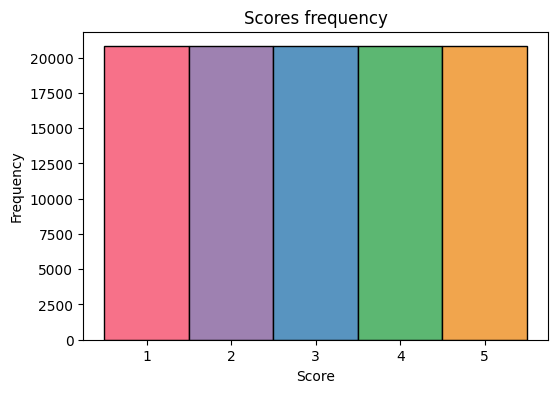

In [ ]:
# Count the number of occurrences for each score
score_counts = df['Score'].value_counts().sort_index()
# Plot the histogram
plt.figure(figsize=(6, 4))

# Iterate over each score and plot a bar with the corresponding color
for score, count in score_counts.items():
    plt.bar(str(score), count, color=score_colors[score], edgecolor='black', width=1)

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Scores frequency')

plt.show()

In [ ]:
# Save the scores vector
score = df['Score']

## BOW and TF-IDF

Starting from the text on which we applied lemmatization, which is the one we will always use, we create the Bag of Words (BOW) and Term Frequency-Inverse Document Frequency (TF-IDF) vector and matrix.

In [ ]:
df['Tokens_lemma'] = df['Tokens_lemma'].astype(str)

In [ ]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['Tokens_lemma'])

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['Tokens_lemma'])

## Dimensionality reduction

After performing Singular Value Decomposition (SVD) to reduce dimensionality, we calculate the explained variance, which is the variance retained through this dimensionality reduction. We select a significantly higher number of features in the TF-IDF case compared to the BOW case to ensure that the values of explained variance are not too different.

In [ ]:
n_components_bow = 400
n_components_tfidf = 1000
svd_bow = TruncatedSVD(n_components = n_components_bow)
svd_tfidf = TruncatedSVD(n_components = n_components_tfidf)

In [ ]:
X_bow_svd = svd_bow.fit_transform(X_bow)
explained_variance_bow = round(svd_bow.explained_variance_ratio_.cumsum()[-1], 3)
print(f"Cumulative Explained Variance BOW: {explained_variance_bow}")

Cumulative Explained Variance BOW: 0.657


In [ ]:
X_tfidf_svd = svd_tfidf.fit_transform(X_tfidf)
explained_variance_tfidf = round(svd_tfidf.explained_variance_ratio_.cumsum()[-1], 3)
print(f"Cumulative Explained Variance TF-IDF: {explained_variance_tfidf}")

Cumulative Explained Variance TF-IDF: 0.569


In [ ]:
bow_df = pd.DataFrame(X_bow_svd, columns=[f'component_{i+1}' for i in range(n_components_bow)])
tfidf_df = pd.DataFrame(X_tfidf_svd, columns=[f'component_{i+1}' for i in range(n_components_tfidf)])

In [ ]:
print(bow_df.shape)
print(tfidf_df.shape)

(103980, 400)
(103980, 1000)


## Splitting in train and test set

We split into training and test sets using the typical ratios of 2/3 - 1/3.

In [ ]:
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(bow_df, score, test_size = 0.33, random_state = 42)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(tfidf_df, score, test_size=0.33, random_state=42)

## Classification

In [ ]:
# the five classes of the multiclass problem
target_classes = [1,2,3,4,5]

### Random Forest

#### BOW

In [ ]:
# Creation of Random Forest model
model_rf = RandomForestClassifier(random_state=42)

model_rf.fit(X_bow_train, y_bow_train)
y_pred_rf = model_rf.predict(X_bow_test)

# Evaluations
accuracy_rf = accuracy_score(y_bow_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2f}')
print('\nClassification Report:')
print(classification_report(y_bow_test, y_pred_rf, target_names=[str(c) for c in target_classes]))

Accuracy: 0.56

Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.65      0.61      6811
           2       0.64      0.60      0.62      6892
           3       0.57      0.53      0.55      6932
           4       0.50      0.44      0.47      6914
           5       0.52      0.57      0.55      6765

    accuracy                           0.56     34314
   macro avg       0.56      0.56      0.56     34314
weighted avg       0.56      0.56      0.56     34314



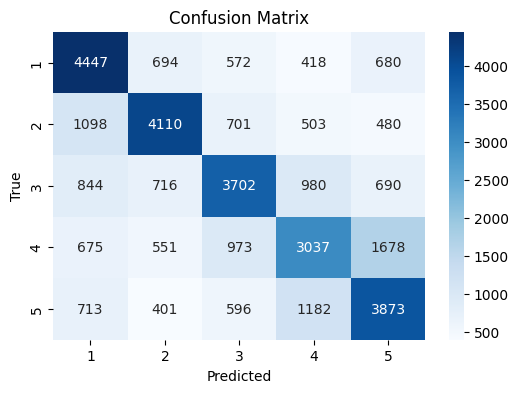

In [ ]:
# Confusion matrix
conf_matrix_rf = confusion_matrix(y_bow_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### TF-IDF

In [ ]:
model_rf = RandomForestClassifier(random_state=42)

model_rf.fit(X_tfidf_train, y_tfidf_train)
y_pred_rf = model_rf.predict(X_tfidf_test)

# Evaluations
accuracy_rf = accuracy_score(y_tfidf_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2f}')
print('\nClassification Report:')
print(classification_report(y_tfidf_test, y_pred_rf, target_names=[str(c) for c in target_classes]))

Accuracy: 0.57

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.69      0.63      6811
           2       0.67      0.59      0.63      6892
           3       0.60      0.52      0.56      6932
           4       0.50      0.46      0.48      6914
           5       0.52      0.61      0.56      6765

    accuracy                           0.57     34314
   macro avg       0.57      0.57      0.57     34314
weighted avg       0.57      0.57      0.57     34314



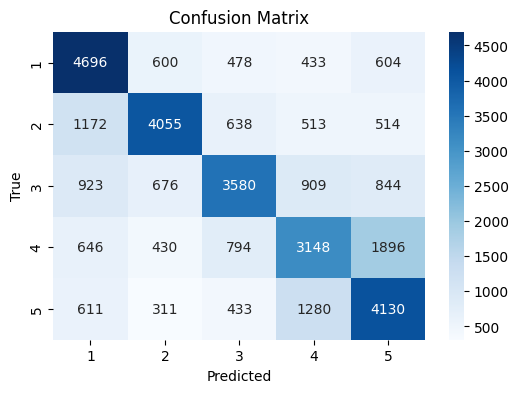

In [ ]:
conf_matrix_rf = confusion_matrix(y_tfidf_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Logistic Regression

#### BOW

In [ ]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)

model_lr.fit(X_bow_train, y_bow_train)
y_pred_lr = model_lr.predict(X_bow_test)

# Evaluations
accuracy_lr = accuracy_score(y_bow_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr:.2f}')
print('\nClassification Report:')
print(classification_report(y_bow_test, y_pred_lr, target_names=[str(c) for c in target_classes]))

Accuracy: 0.46

Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.64      0.57      6811
           2       0.38      0.31      0.34      6892
           3       0.40      0.32      0.36      6932
           4       0.43      0.37      0.40      6914
           5       0.54      0.69      0.60      6765

    accuracy                           0.46     34314
   macro avg       0.45      0.47      0.45     34314
weighted avg       0.45      0.46      0.45     34314



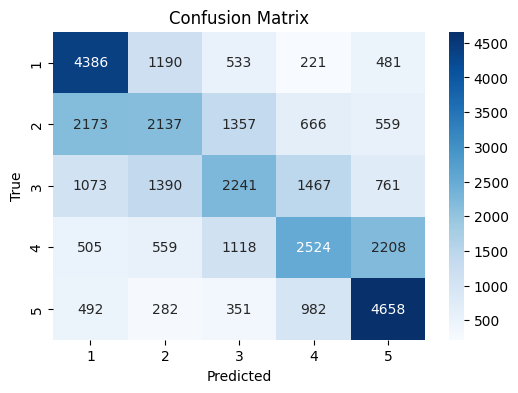

In [ ]:
conf_matrix_rf = confusion_matrix(y_bow_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### TF-IDF

In [ ]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)

model_lr.fit(X_tfidf_train, y_tfidf_train)
y_pred_lr = model_lr.predict(X_tfidf_test)

# Evaluations
accuracy_lr = accuracy_score(y_tfidf_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr:.2f}')
print('\nClassification Report:')
print(classification_report(y_tfidf_test, y_pred_lr, target_names=[str(c) for c in target_classes]))

Accuracy: 0.51

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.66      0.61      6811
           2       0.43      0.40      0.42      6892
           3       0.43      0.38      0.40      6932
           4       0.47      0.42      0.45      6914
           5       0.60      0.69      0.64      6765

    accuracy                           0.51     34314
   macro avg       0.50      0.51      0.50     34314
weighted avg       0.50      0.51      0.50     34314



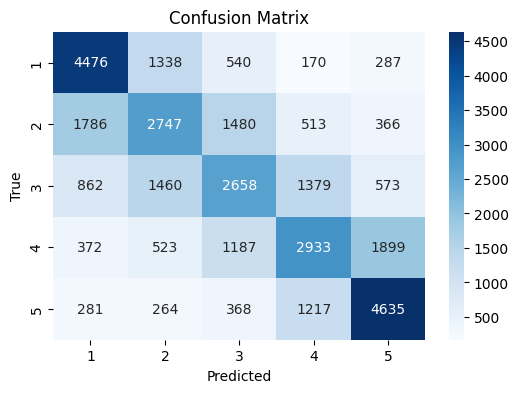

In [ ]:
conf_matrix_rf = confusion_matrix(y_tfidf_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

SVM non lo faccio perché non rende sul multiclasse

### XGBoost

#### BOW

In [ ]:
# We manually change classes from [1, 2, 3, 4, 5] to [0, 1, 2, 3, 4] to adapt to the model
y_bow_train_changed = y_bow_train - 1
y_bow_test_changed = y_bow_test - 1

model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(target_classes), random_state=42)

model.fit(X_bow_train, y_bow_train_changed)
y_pred_changed = model.predict(X_bow_test)

# We return to the original classes
y_pred = y_pred_changed + 1

# Evaluations
accuracy = accuracy_score(y_bow_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_bow_test, y_pred, target_names=[str(c) for c in target_classes]))

Accuracy: 0.57

Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.67      0.64      6811
           2       0.58      0.57      0.57      6892
           3       0.55      0.52      0.53      6932
           4       0.51      0.46      0.49      6914
           5       0.57      0.62      0.60      6765

    accuracy                           0.57     34314
   macro avg       0.56      0.57      0.57     34314
weighted avg       0.56      0.57      0.56     34314



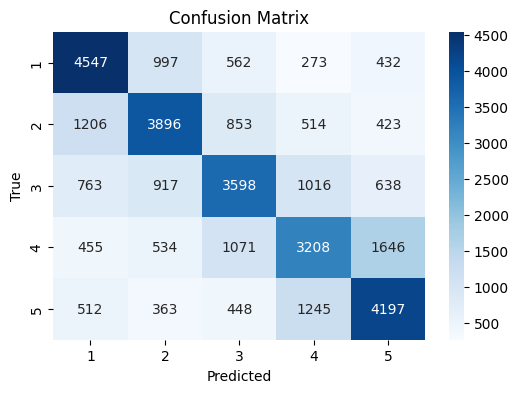

In [ ]:
conf_matrix_rf = confusion_matrix(y_bow_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### TF-IDF

In [ ]:
# We manually change classes from [1, 2, 3, 4, 5] to [0, 1, 2, 3, 4] to adapt to the model
y_tfidf_train_changed = y_bow_train - 1
y_tfidf_test_changed = y_bow_test - 1

model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(target_classes), random_state=42)

model.fit(X_tfidf_train, y_tfidf_train_changed)
y_pred_changed = model.predict(X_tfidf_test)

# We return to the original classes
y_pred = y_pred_changed + 1

# Evaluations
accuracy = accuracy_score(y_tfidf_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_tfidf_test, y_pred, target_names=[str(c) for c in target_classes]))

Accuracy: 0.59

Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.70      0.67      6811
           2       0.60      0.60      0.60      6892
           3       0.58      0.53      0.56      6932
           4       0.52      0.49      0.51      6914
           5       0.60      0.64      0.62      6765

    accuracy                           0.59     34314
   macro avg       0.59      0.59      0.59     34314
weighted avg       0.59      0.59      0.59     34314



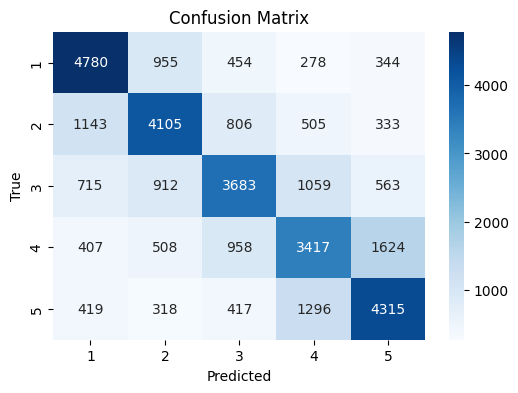

In [ ]:
conf_matrix_rf = confusion_matrix(y_tfidf_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Binary classification

In [ ]:
# Specify the file path
# file_path = '/content/gdrive/MyDrive/Text_Mining_ Project/files_csv/binaria_df.csv' # sam
file_path = '/content/gdrive/MyDrive/binaria_df.csv' # davide

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=",")
df

,Tokens_lemma,Score
0,"['first', 'researched', 'lamb', 'lung', 'know'...",0
1,"['one', 'bin', 'arrived', 'broken', 'brine', '...",0
2,"['celestial', 'seasoning', 'zinger', 'herbal',...",0
3,"['drink', 'tea', 'year', 'tell', 'tea', 'suck'...",0
4,"['background', 'preparing', 'escargot', 'year'...",0
...,...,...
83179,"['far', 'better', 'gummies', 'market', 'great'...",1
83180,"['back', 'nature', 'chocolate', 'delight', 'gr...",1
83181,"['really', 'got', 'tired', 'buying', 'grocery'...",1
83182,"['order', 'came', 'quickly', 'described', 'adv...",1


In [ ]:
print(df.shape)

(83184, 2)


In [ ]:
#  Convert score column to binary values
df['Score'] = df['Score'].apply(lambda x: 0 if x in [1, 2] else 1)

In [ ]:
score_colors = {0: '#9e81b1', 1: '#f77189'}

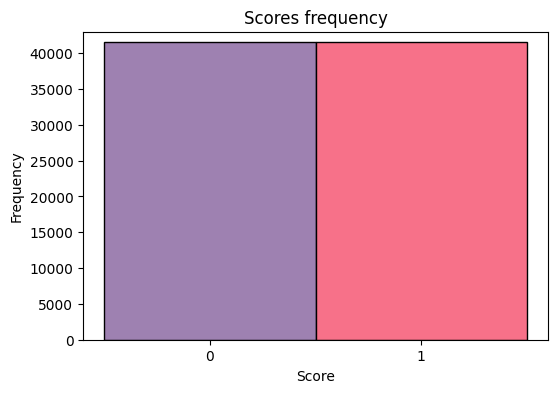

In [ ]:
# Count the number of occurrences for each score
score_counts = df['Score'].value_counts().sort_index()
# Plot the histogram
plt.figure(figsize=(6, 4))

# Iterate over each score and plot a bar with the corresponding color
for score, count in score_counts.items():
    plt.bar(str(score), count, color=score_colors[score], edgecolor='black', width=1)
plt.ylim(0, 43000)

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Scores frequency')

plt.show()

In [ ]:
# Save the scores vector
score = df['Score']

Now we proceed with the exact same steps as in the multiclass case.

## BOW and TF-IDF

In [ ]:
df['Tokens_lemma'] = df['Tokens_lemma'].astype(str)

In [ ]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['Tokens_lemma'])

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['Tokens_lemma'])

## Dimensionality reduction

In [ ]:
n_components_bow = 400
n_components_tfidf = 1000
svd_bow = TruncatedSVD(n_components = n_components_bow)
svd_tfidf = TruncatedSVD(n_components = n_components_tfidf)

In [ ]:
X_bow_svd = svd_bow.fit_transform(X_bow)
explained_variance_bow = round(svd_bow.explained_variance_ratio_.cumsum()[-1], 3)
print(f"Cumulative Explained Variance BOW: {explained_variance_bow}")

Cumulative Explained Variance BOW: 0.651


In [ ]:
X_tfidf_svd = svd_tfidf.fit_transform(X_tfidf)
explained_variance_tfidf = round(svd_tfidf.explained_variance_ratio_.cumsum()[-1], 3)
print(f"Cumulative Explained Variance TF-IDF: {explained_variance_tfidf}")

Cumulative Explained Variance TF-IDF: 0.569


In [ ]:
bow_df = pd.DataFrame(X_bow_svd, columns=[f'component_{i+1}' for i in range(n_components_bow)])
tfidf_df = pd.DataFrame(X_tfidf_svd, columns=[f'component_{i+1}' for i in range(n_components_tfidf)])

In [ ]:
print(bow_df.shape)
print(tfidf_df.shape)

(83184, 400)
(83184, 1000)


## Splitting in train and test set

In [ ]:
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(bow_df, score, test_size = 0.33, random_state = 42)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(tfidf_df, score, test_size=0.33, random_state=42)

## Classification

In [ ]:
# the five classes of the multiclass problem
target_classes = [0,1]

### Random Forest

#### BOW

In [ ]:
model_rf = RandomForestClassifier(random_state=42)

model_rf.fit(X_bow_train, y_bow_train)
y_pred_rf = model_rf.predict(X_bow_test)

# Evaluations
accuracy_rf = accuracy_score(y_bow_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2f}')
print('\nClassification Report:')
print(classification_report(y_bow_test, y_pred_rf, target_names=[str(c) for c in target_classes]))

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     13687
           1       0.83      0.79      0.81     13764

    accuracy                           0.82     27451
   macro avg       0.82      0.82      0.82     27451
weighted avg       0.82      0.82      0.82     27451



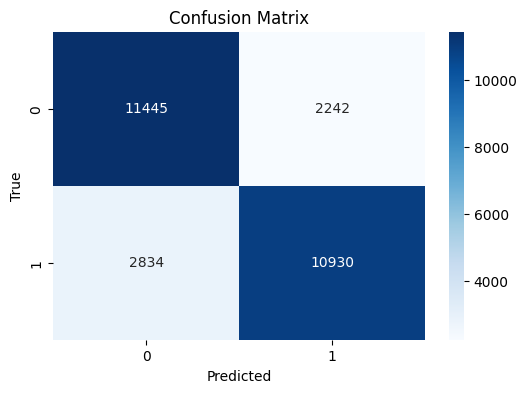

In [ ]:
conf_matrix_rf = confusion_matrix(y_bow_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### TF-IDF

In [ ]:
model_rf = RandomForestClassifier(random_state=42)

model_rf.fit(X_tfidf_train, y_tfidf_train)
y_pred_rf = model_rf.predict(X_tfidf_test)

# Evaluations
accuracy_rf = accuracy_score(y_tfidf_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2f}')
print('\nClassification Report:')
print(classification_report(y_tfidf_test, y_pred_rf, target_names=[str(c) for c in target_classes]))

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     13687
           1       0.85      0.81      0.83     13764

    accuracy                           0.84     27451
   macro avg       0.84      0.84      0.84     27451
weighted avg       0.84      0.84      0.84     27451



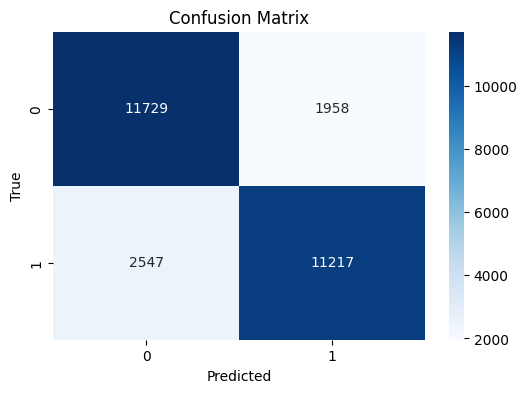

In [ ]:
conf_matrix_rf = confusion_matrix(y_tfidf_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Logistic Regression

#### BOW

In [ ]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)

model_lr.fit(X_bow_train, y_bow_train)
y_pred_lr = model_lr.predict(X_bow_test)

# Evaluations
accuracy_lr = accuracy_score(y_bow_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr:.2f}')
print('\nClassification Report:')
print(classification_report(y_bow_test, y_pred_lr, target_names=[str(c) for c in target_classes]))

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     13687
           1       0.82      0.83      0.82     13764

    accuracy                           0.82     27451
   macro avg       0.82      0.82      0.82     27451
weighted avg       0.82      0.82      0.82     27451



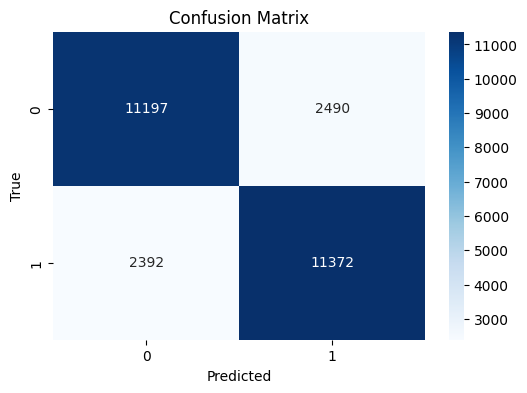

In [ ]:
conf_matrix_rf = confusion_matrix(y_bow_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### TF-IDF

In [ ]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)

model_lr.fit(X_tfidf_train, y_tfidf_train)
y_pred_lr = model_lr.predict(X_tfidf_test)

# Evaluations
accuracy_lr = accuracy_score(y_tfidf_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr:.2f}')
print('\nClassification Report:')
print(classification_report(y_tfidf_test, y_pred_lr, target_names=[str(c) for c in target_classes]))

Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86     13687
           1       0.85      0.86      0.86     13764

    accuracy                           0.86     27451
   macro avg       0.86      0.86      0.86     27451
weighted avg       0.86      0.86      0.86     27451



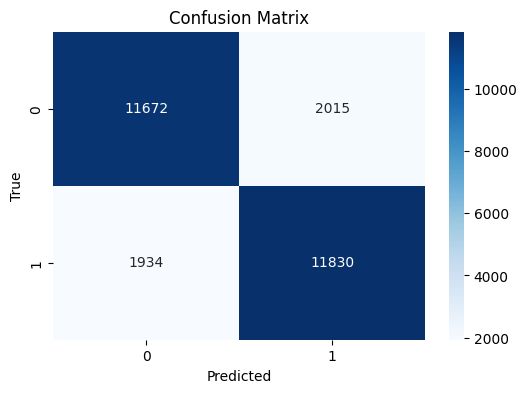

In [ ]:
conf_matrix_rf = confusion_matrix(y_tfidf_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### XGBoost

#### BOW

In [ ]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(target_classes), random_state=42)

model.fit(X_bow_train, y_bow_train)
y_pred = model.predict(X_bow_test)

# Evaluations
accuracy = accuracy_score(y_bow_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_bow_test, y_pred, target_names=[str(c) for c in target_classes]))

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     13687
           1       0.83      0.85      0.84     13764

    accuracy                           0.84     27451
   macro avg       0.84      0.84      0.84     27451
weighted avg       0.84      0.84      0.84     27451



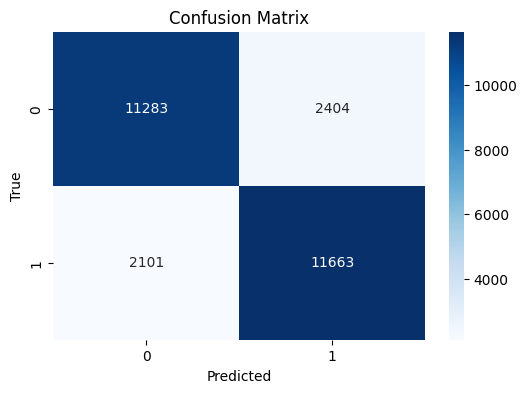

In [ ]:
conf_matrix_rf = confusion_matrix(y_bow_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### TF-IDF

In [ ]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(target_classes), random_state=42)

model.fit(X_tfidf_train, y_tfidf_train)
y_pred = model.predict(X_tfidf_test)

# Evaluations
accuracy = accuracy_score(y_tfidf_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_tfidf_test, y_pred, target_names=[str(c) for c in target_classes]))

Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86     13687
           1       0.85      0.87      0.86     13764

    accuracy                           0.86     27451
   macro avg       0.86      0.86      0.86     27451
weighted avg       0.86      0.86      0.86     27451



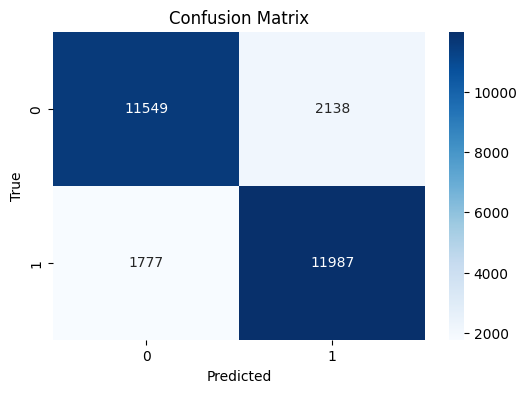

In [ ]:
conf_matrix_rf = confusion_matrix(y_tfidf_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM

#### BOW

In [ ]:
svm_model = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)

svm_model.fit(X_bow_train, y_bow_train)
y_pred_svm = svm_model.predict(X_bow_test)

# Evaluations
accuracy_svm = accuracy_score(y_bow_test, y_pred_svm)
print(f'Accuracy: {accuracy_svm:.2f}')
print('\nClassification Report:')
print(classification_report(y_bow_test, y_pred_svm, target_names=[str(c) for c in target_classes]))

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     13687
           1       0.82      0.83      0.82     13764

    accuracy                           0.82     27451
   macro avg       0.82      0.82      0.82     27451
weighted avg       0.82      0.82      0.82     27451



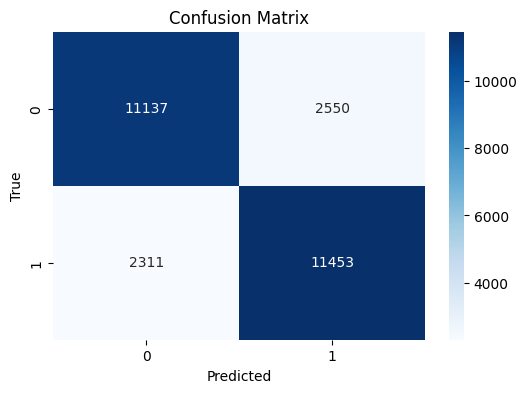

In [ ]:
conf_matrix_rf = confusion_matrix(y_bow_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### TF-IDF

In [ ]:
svm_model = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)

svm_model.fit(X_tfidf_train, y_tfidf_train)
y_pred_svm = svm_model.predict(X_tfidf_test)

# Evaluations
accuracy_svm = accuracy_score(y_tfidf_test, y_pred_svm)
print(f'Accuracy: {accuracy_svm:.2f}')
print('\nClassification Report:')
print(classification_report(y_tfidf_test, y_pred_svm))

Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     13687
           1       0.85      0.86      0.86     13764

    accuracy                           0.86     27451
   macro avg       0.86      0.86      0.86     27451
weighted avg       0.86      0.86      0.86     27451



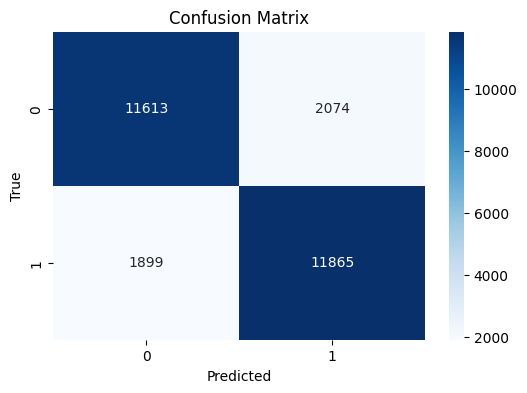

In [ ]:
conf_matrix_rf = confusion_matrix(y_tfidf_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()